### *Modelling ancient areas for date palms (Phoenix species, Arecaceae): Bayesian analysis of biological and cultural evidence*

Select **Cell-> Run All** to get interactive maps.

(Press the button [^] to show the source code.)

## Individual evidences

<IPython.core.display.Javascript object>


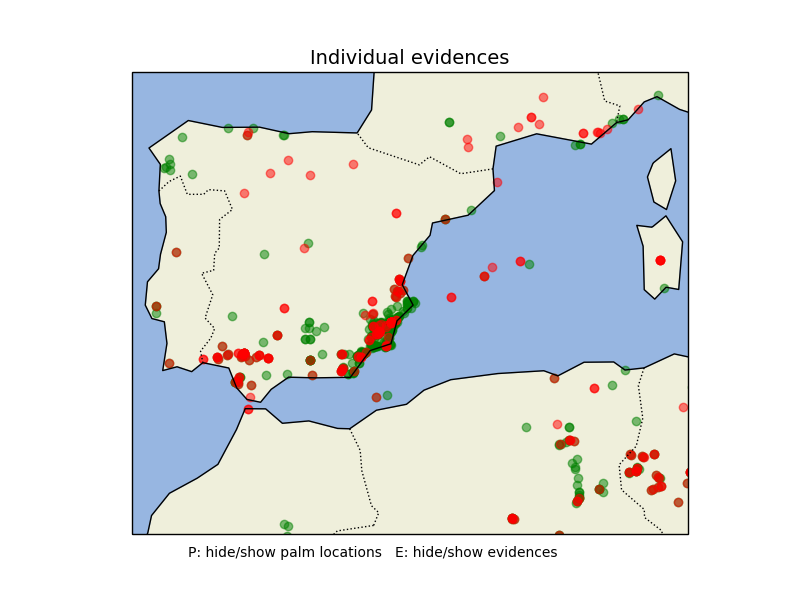

In [1]:
%matplotlib notebook

import pandas as pd
import numpy as np
from collections import Counter

df = pd.read_csv('http://robot.inf.um.es/material/data/evidence_data.csv',sep=';')

evi_name = list(df.columns)[4:18]
evi_short = "palmGrov coin datRe inflor leave stemCh pollen phytol texts potter paint jewel rockP sculpt".split()

bindf = df[df.columns[4:18]]

palm_type = list(df.Taxa[df["Palm groves"]==1])

bindata = np.array(bindf)

location = df[["Longitude","Latitude"]].apply(np.vectorize(lambda x: float(x.replace(',','.'))))



import cartopy
import cartopy.feature as cpf
import matplotlib.pyplot as plt

import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

lat_lon = cartopy.crs.PlateCarree()

def genmap(extent, figsize, grid=2):
    fig = plt.figure(figsize=figsize)
    ax = fig.gca(projection=cartopy.crs.Mercator())
    lon1,lon2,lat1,lat2 = extent
    
    ax.add_feature(cpf.LAND)
    ax.add_feature(cpf.OCEAN)
    ax.add_feature(cpf.COASTLINE)
    ax.add_feature(cpf.BORDERS, linestyle=':')
    ax.add_feature(cpf.LAKES,   alpha=0.5)
    ax.add_feature(cpf.RIVERS)

    if grid is not None:
        gl = ax.gridlines(crs=lat_lon, draw_labels=True,
                          linewidth=2, color='gray', alpha=0.5, linestyle='--')
        gl.xlabels_top = False
        gl.ylabels_left = False
        gl.xlines = True
        gl.ylocator = mticker.FixedLocator(range(lat1-grid,lat2+grid,grid))
        gl.xlocator = mticker.FixedLocator(range(lon1-grid,lon2+grid,grid))
        gl.xformatter = LONGITUDE_FORMATTER
        gl.yformatter = LATITUDE_FORMATTER
        gl.xlabel_style = {'size': 8, 'color': 'gray'}
        gl.ylabel_style = {'size': 12, 'color': 'gray'}

    ax.set_extent(extent,crs=lat_lon)
    return fig


pos_idx = bindata[:,0]==1
neg_idx = bindata[:,0]==0

fig = genmap(figsize=(8,6), extent=[-10, 10, 32, 45], grid=None)
#genmap(figsize=(18,18), extent=[-20,70,4,54], grid=None);
pos = plt.scatter(*np.array(location[pos_idx]).T, transform=lat_lon, alpha=0.5,color='green');
neg = plt.scatter(*np.array(location[neg_idx]).T, transform=lat_lon, alpha=0.5,color='red');

plt.text(0.1,-0.05,"P: hide/show palm locations   E: hide/show evidences", transform=fig.gca().transAxes)
plt.title('Individual evidences',fontsize=14);
cosa = plt.text(0,40,'',transform=lat_lon,fontsize=10)

def hover(event):
    
    cont, ind = pos.contains(event)
    if cont:
        p = pos.get_offsets()[ind["ind"][0]]
        cosa.set_position(p)
        k = ind["ind"][0]
        cosa.set_text(palm_type[k])
        fig.canvas.draw_idle()
        

    cont, ind = neg.contains(event)
    if cont:
        p = neg.get_offsets()[ind["ind"][0]]
        cosa.set_position(p)
        k = ind["ind"][0]
        v = bindata[neg_idx][k]
        cosa.set_text(evi_short[np.argmax(v)])
        fig.canvas.draw_idle()
        
fig.canvas.mpl_connect("motion_notify_event", hover);

def on_key_press(event):
    if event.key == 'p':
        pos.set_visible(not pos.get_visible())
    if event.key == 'e':
        neg.set_visible(not neg.get_visible())
    fig.canvas.draw_idle()
        
fig.canvas.mpl_connect('key_press_event', on_key_press);

## Results

<IPython.core.display.Javascript object>


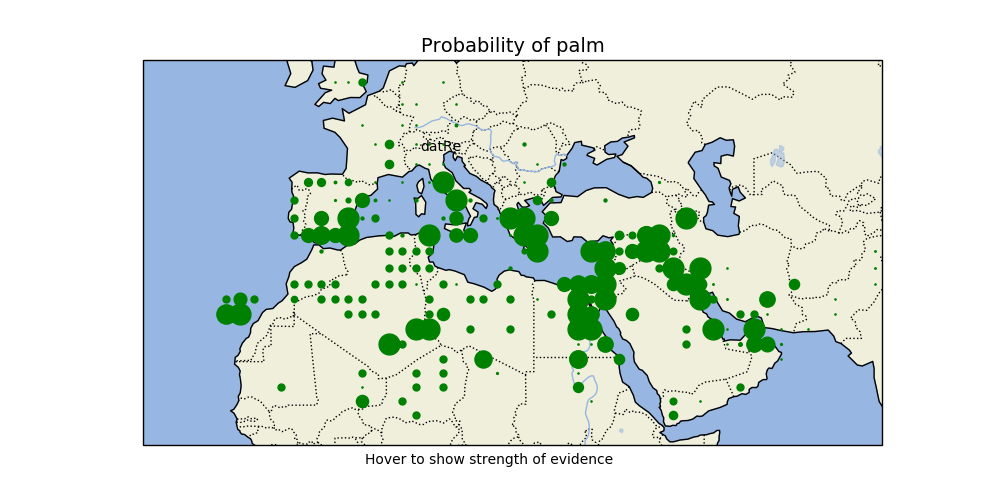

In [2]:
def makeGrid(size=2, offset=0):
    fun = lambda x: np.floor_divide(x-offset,size).astype(int)
    x1,x2,y1,y2 = fun(np.array(region))-[0,1,0,1]
    #print(x1,x2,y1,y2)
    celllocs = np.array( location.apply(fun ))
    cells = {tuple(x) for x in celllocs}
    allcells = {(x,y) for x in range(x1,x2+1) for y in range(y1,y2+1)}
    #emptycells = allcells.difference(cells)
    #print(len(emptycells))
    celldic = { x : np.where( np.all(celllocs == x,axis=1) )[0] for x in allcells }
    data  = { x: bindata[v] for x,v in celldic.items() }
    dataN = { x: d.sum(axis=0) for x,d in data.items() }
    dataB = { x: (v>0).astype(int) for x,v in dataN.items() }
    dataP = { x: v[1:] for x,v in dataB.items() if v[0] == 1 }
    dataN = { x: v[1:] for x,v in dataB.items() if v[0] == 0 }
    S = np.array([v for _,v in dataP.items()]).mean(axis=0)
    E = np.array([1-v for _,v in dataN.items()]).mean(axis=0)
    loc = lambda x: size/2 + x*size + offset
    dataL = { x: loc(np.array(x)) for x in allcells }
    return data, dataB, dataP, dataN, dataL, S,E


def sig(z):
    return 1/(1+10**(-z/10))

def lb(p):
    return 10*np.log10(max(p,1e-20))

def llr(p):
    return lb(p) - lb(1-p)

def mkTest(s,e):
    p = lb(s)   - lb(1-e)
    n = lb(1-s) - lb(e) 
    return lambda x: p if x else n


#region = [0,10,0,10]
region = [-30,74,10,54]

Ss,Es  = zip(* [ makeGrid( s,o)[-2:] for s in [1.5, 1.75, 2, 2.25, 2.5, 3] for o in [s*v for v in [0,0.1,0.2,0.3,0.4,0.5]]])
Ss = np.array(Ss)
Es = np.array(Es)

tests = [ mkTest(s,e) for s,e in zip(np.mean(Ss,axis=0),np.mean(Es,axis=0)) ]

def showTest(test):
    bins = np.linspace(0,1,30)
    plt.hist(Ss[:,test], density=True,alpha=0.7, bins=bins);
    plt.hist(Es[:,test], density=True,alpha=0.7, bins=bins);
    testname = list(df.columns)[test+5]
    #plt.title('{}\n s={:.2f}({:.2f}),  e={:.2f}({:.2f})\n {:.1f} | {:.1f} db'.format(testname,Ss[:,test].mean(),Ss[:,test].std() , Es[:,test].mean(), Es[:,test].std(),
     #         tests[test](True),tests[test](False)))
    plt.text(0.2,25,'s={:.2f}({:.2f}),  e={:.2f}({:.2f})\n {:.1f} | {:.1f} db'.format(Ss[:,test].mean(),Ss[:,test].std() , Es[:,test].mean(), Es[:,test].std(),
              tests[test](True),tests[test](False)),color='gray')
    plt.title(testname)
    plt.xlim(0,1); plt.ylim(0,30);


# [Jeffreys scale of evidence](https://en.wikipedia.org/wiki/Bayes_factor#Interpretation)

def colorpred(t,p):
    if t==1 and p>0.5: return 'green'
    if t==0 and p<0.5: return 'black'
    if t==0 and p>0.5: return (0.3,0.8,0.3)
    if t==1 and p<0.5: return 'gray'

def colorevidence(t,e):
    if e<5: return 'green'
    if t==0 and p<0.5: return 'black'
    if t==0 and p>0.5: return (0.3,0.8,0.3)
    if t==1 and p<0.5: return 'gray'
    
    
#dataB, _, _, dataL, _, _ = makeGrid()
_, dataB, _, _, dataL, _, _ = makeGrid(size=1.9,offset=-0.15)


fig = genmap(figsize=(10,5), extent=region, grid=None)

pl=[]
vl=[]
el=[]

for c,v in (dataB).items():
    e = sum([t(x) for t,x in zip(tests,v[1:])])
    p = sig(e)
    col = colorpred(v[0],p)
    if e>0:
        vl.append(v[1:])
        pl.append(dataL[c])
        el.append((e,p))
        plt.plot(*dataL[c],'.',color='green', markerSize=min(e,30), transform=lat_lon)

plt.title('Probability of palm', fontsize=14)
plt.text(0.3,-0.05,"Hover to show strength of evidence", transform=fig.gca().transAxes)
cosa = plt.text(0,40,'',transform=lat_lon,fontsize=10)        
ax = fig.gca()

def on_plot_hover(event):
    for k,curve in enumerate(ax.get_lines()):
        if curve.contains(event)[0]:
            e,p = el[k]
            cosa.set_text(f'{e:.0f}db, {100*p:.2f}%\n'+', '.join([evi_short[1+x] for x in np.where(vl[k])[0]]))
            cosa.set_position(pl[k])
            fig.canvas.draw_idle()

fig.canvas.mpl_connect('motion_notify_event', on_plot_hover);